In [1]:
from matplotlib import pyplot as plt
import numpy as np
import re

In [2]:
plt.style.use('ggplot')

In [3]:
fileName = "new.csv"
numHeaderLines = 4
delimiter = ","
yDataNames = ["time", "RKneeOut_x", "RKneeOut_y","RKneeOut_z",
              "RKneeIn_x","RKneeIn_y","RKneeIn_z",
              "RThigh_x","RThigh_y", "RThigh_z", 
              "RAsis_x", "RAsis_y", "RAsis_z",
              "RPsi_x", "RPsi_y", "RPsi_z",
              "LAsis_x", "LAsis_y", "LAsis_z",
              "LPsi_x", "LPsi_y", "LPsi_z"]

regrexHeader = r'\w+'
Data = np.genfromtxt(fileName, delimiter=delimiter, skip_header=numHeaderLines+1)

with open(fileName) as infile:
    content = infile.readlines()
    row = content[numHeaderLines]
headers = row.split(delimiter)

dataIdx = {}
for i, header in enumerate(headers):
    x = re.findall(regrexHeader, header)
    if x: 
        if (x[0] in yDataNames):
            dataIdx.update({x[0] : i})

fileData = np.zeros((Data.shape[0], len(yDataNames)))
for i,name in enumerate(yDataNames):
    fileData[:,i] = Data[:, dataIdx[name]]
    
time = fileData[:, dataIdx["time"]]

In [4]:
class Screw:
    def __init__(self, rho=None, dirCos=None, theta=None, translation=None):
        self.rho = rho
        self.dirCos = dirCos
        self.theta = theta
        self.translation = translation
        return None

In [5]:
def ComputeScrew(bodyVecs, globalVecs):
    nVecs = bodyVecs.shape[0]
    displacementVecs = globalVecs - bodyVecs
    relativeDispalcmentVecs = displacementVecs - np.tile(displacementVecs[0,:], (nVecs,1))
    
    if np.linalg.norm(relativeDispalcmentVecs) < 1e-2:
        #print("Detected Pure Translation")
        meanDispalcementVec = np.mean(displacementVecs, axis=0) 
        d = np.linalg.norm(meanDispalcementVec)
        dirCos = meanDispalcementVec/d
        return Screw(np.zeros(3), dirCos, 0.0, d)
    else:
        # This method for direction cosines can handle more than three points  is based on 
        # https://math.stackexchange.com/questions/1833035/minimizing-ax-2-subject-to-x-2-1
        u,s,vh = np.linalg.svd(relativeDispalcmentVecs)
        dirCos = vh[-1,:]
    
        #print(Matrix(relativeDispalcmentVecs).nullspace()) 
        #dirCos = Matrix(relativeDispalcmentVecs).nullspace()[-1]
        #dirCos = np.array(dirCos.tolist()).astype(np.float64)
        #dirCos = dirCos.reshape(3,)/np.linalg.norm(dirCos)
    
        d = np.dot(dirCos, displacementVecs[0])
        translationVec = d*dirCos

        perpVecs = displacementVecs - np.tile(translationVec, (nVecs,1))
        perpVecs_midPoint = bodyVecs + perpVecs/2

        A = np.concatenate((perpVecs, [dirCos]), axis=0)

        b = np.concatenate((np.diagonal(np.dot(perpVecs, perpVecs_midPoint.T)).reshape(-1,1), 
                        np.array([[0.0],])), axis =0)
    
        # point on the screw axis that is nearest to the origin
        rho = np.linalg.lstsq(A, b, rcond=None)[0].reshape(3,)
        
        for i in range(perpVecs.shape[0]):
            vec = perpVecs_midPoint[i]-rho
            vec_perp = vec-np.dot(dirCos, vec)
            Base = np.linalg.norm(vec_perp)
            if (Base>1e-2):
                Perp = np.linalg.norm(perpVecs[i]/2)
                sign = np.sign(np.dot(dirCos, np.cross(vec_perp, perpVecs[i])))
                theta = sign*2*np.arctan(Perp/Base)
                break

        return Screw(rho, dirCos, theta, d)

In [6]:
def TransfromationMatrix(screw):
    k_norm = np.linalg.norm(screw.dirCos)
    if(k_norm >1e-3):
        kx = screw.dirCos[0]/k_norm
        ky = screw.dirCos[1]/k_norm
        kz = screw.dirCos[2]/k_norm
    else:
        return None

    K = np.array([[0, -kz, ky],[kz, 0, -kx],[-ky, kx, 0]])
    r = np.sin(screw.theta)*K + (1-np.cos(screw.theta))*np.dot(K,K)
    rho = np.reshape(screw.rho, (-1,1))
    mat_rodriguez = r + np.identity(3)
    translation_offset = np.dot(-r,rho)+ screw.translation*np.array([[kx], [ky], [kz]])
    transform_Mat = np.concatenate((mat_rodriguez, translation_offset), axis=1)
    transform_Mat =  np.concatenate(( transform_Mat, np.array([[0, 0, 0, 1]])) ,axis=0)
    return transform_Mat

In [7]:
pelvisBodyVecs = np.array([[0.011497800000000001, 0.0197974, 0.128],
                   [-0.15606900000000001, 0.039409800000000002, 0.055399799999999999],
                   [0.011497800000000001, 0.0197974, -0.128],
                   [-0.15606900000000001, 0.039541, -0.055399799999999999]], dtype=np.double)


i = 206
pelvisGlobalVecs = np.reshape(fileData[i,10:], (4,3))
pelvis_screw = ComputeScrew(pelvisBodyVecs, pelvisGlobalVecs)
pelvis_transformMat = TransfromationMatrix(pelvis_screw)
print(pelvis_transformMat)

[[ 0.92845879 -0.37143542  0.         -0.05526066]
 [ 0.37143542  0.92845879  0.          0.63499275]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [8]:
i = 207
pelvisGlobalVecs = np.reshape(fileData[i,10:], (4,3))
pelvis_screw = ComputeScrew(pelvisBodyVecs, pelvisGlobalVecs)
pelvis_transformMat = TransfromationMatrix(pelvis_screw)
print(pelvis_transformMat)

[[ 9.49255190e-01 -3.14506891e-01  2.10805785e-14 -3.04899113e-02]
 [ 3.14506891e-01  9.49255190e-01 -9.51419364e-14  5.37171156e-01]
 [ 9.91194602e-15  9.69439641e-14  1.00000000e+00 -4.91530732e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
pelvisBodyVecs = np.array([[0.011497800000000001, 0.0197974, 0.128],
                   [-0.15606900000000001, 0.039409800000000002, 0.055399799999999999],
                   [0.011497800000000001, 0.0197974, -0.128],
                   [-0.15606900000000001, 0.039541, -0.055399799999999999]], dtype=np.double)


femurBodyVecs = np.array([[0.015749900000000001, -0.40403899999999998, 0.0498872],
                   [0.0046475099999999997, -0.40554099999999998, -0.048730299999999997],
                   [0.0092257799999999994, -0.121377, 0.089914999999999995]])

nRows = fileData.shape[0]
pelvisOriginGlobal = np.zeros((nRows,3))
femurOriginGlobal = np.zeros((nRows,3))

for i in range(nRows):
    pelvisGlobalVecs = np.reshape(fileData[i,10:], (4,3))
    pelvis_screw = ComputeScrew(pelvisBodyVecs, pelvisGlobalVecs)
    pelvis_transformMat = TransfromationMatrix(pelvis_screw)
    pelvisOriginGlobal[i,:] = pelvis_transformMat[0:3,3]
    
    femurGlobalVecs = np.reshape(fileData[i,1:10], (3,3))
    femur_screw = ComputeScrew(femurBodyVecs, femurGlobalVecs)
    femur_transformMat = TransfromationMatrix(femur_screw)
    femurOriginGlobal[i,:] = femur_transformMat[0:3,3]

vin = np.concatenate((time.reshape(-1,1),femurOriginGlobal), axis=1)
np.savetxt("predicted.txt", vin, delimiter=",")

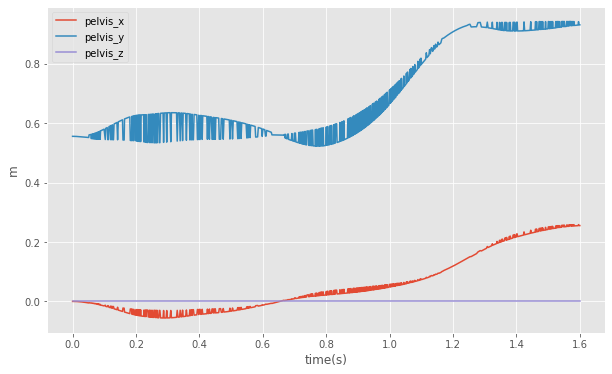

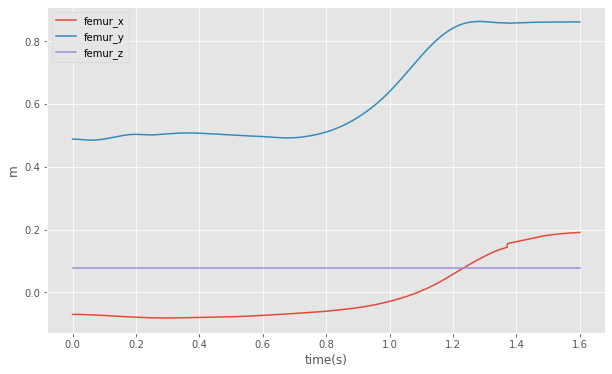

In [10]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.plot(time, pelvisOriginGlobal[:,0], label="pelvis_x")
axs.plot(time, pelvisOriginGlobal[:,1], label="pelvis_y")
axs.plot(time, pelvisOriginGlobal[:,2], label="pelvis_z")
axs.set_xlabel("time(s)")
axs.set_ylabel("m")
axs.legend()

fig, axs1 = plt.subplots(1, 1, figsize=(10, 6))
axs1.plot(time, femurOriginGlobal[:,0], label="femur_x")
axs1.plot(time, femurOriginGlobal[:,1], label="femur_y")
axs1.plot(time, femurOriginGlobal[:,2], label="femur_z")
axs1.set_xlabel("time(s)")
axs1.set_ylabel("m")
axs1.legend()

plt.show()

In [13]:
# femur body vecs [RKneeOut, RKneeIn, RThigh]
time = fileData[:, dataIdx["time"]]
femurBodyVecs = np.array([[0.015749900000000001, -0.40403899999999998, 0.0498872],
                   [0.0046475099999999997, -0.40554099999999998, -0.048730299999999997],
                   [0.0092257799999999994, -0.121377, 0.089914999999999995]])

pelvisBodyVecs = np.array([[0.011497800000000001, 0.0197974, 0.128],
                   [-0.15606900000000001, 0.039409800000000002, 0.055399799999999999],
                   [0.011497800000000001, 0.0197974, -0.128],
                   [-0.15606900000000001, 0.039541, -0.055399799999999999]])

nRows = fileData.shape[0]
A = np.zeros((3*nRows, 6))
b = np.zeros((3*nRows, 1))

for i in range(nRows):
    femurGlobalVecs = np.reshape(fileData[i,1:10], (3,3))
    femur_screw = ComputeScrew(femurBodyVecs, femurGlobalVecs)
    femur_transformMat = TransfromationMatrix(femur_screw)
    
    pelvisGlobalVecs = np.reshape(fileData[i,10:], (4,3))
    pelvis_screw = ComputeScrew(pelvisBodyVecs, pelvisGlobalVecs)
    pelvis_transformMat = TransfromationMatrix(pelvis_screw)
    
    R_femur_pelvis = -np.dot(pelvis_transformMat[0:3, 0:3].T, femur_transformMat[0:3, 0:3])
    A[3*i:3*(i+1), :] = np.concatenate((np.identity(3), R_femur_pelvis), axis=1);
    
    femur_pelvis_pos_global = femur_transformMat[0:3,3] - pelvis_transformMat[0:3,3]
    femur_pelvis_pos = np.dot(pelvis_transformMat[0:3, 0:3].T,femur_pelvis_pos_global)
    b[3*i:3*(i+1), 0] = femur_pelvis_pos.T

vin = np.linalg.lstsq(A,b)[0]
print(vin)

[[-6.84585615e-02]
 [-7.79279649e-02]
 [ 2.33149516e+10]
 [-1.24509679e-02]
 [-3.04167257e-03]
 [ 2.33149516e+10]]


<ipython-input-13-fb1319c9619b>:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vin = np.linalg.lstsq(A,b)[0]
